In [1]:
import numpy as np
import pandas as pd
import sympy as sym
from sympy import symbols, simplify, trigsimp, expand
from matplotlib import pyplot as plt


from Calculation.geometry_util import pol2cart, cart2pol, r_ort, tet_ort, phi_ort
from Calculation.material import StaticMaterial, Material, LayeredFilm, Hk2KuJ, print_Hext_parameters

In [2]:
moke_H = np.array([1530, 2295, 3060, 3825, 4590])
data_s = dict()
data_d = dict()
for H in moke_H:
    data_s[H] = pd.read_csv('data/moke/single_{}Oe.txt'.format(H), sep='\t')
    data_d[H] = pd.read_csv('data/moke/double_{}Oe.txt'.format(H), sep='\t')
    
    data_s[H].dtet*=1e6
    data_d[H].dtet*=1e6
    
    data_s[H].t*=1e-12
    data_d[H].t*=1e-12


In [94]:
ind=2
print("H={} Oe".format(moke_H[ind]))
wtt = data_d[moke_H[ind]].t
wtd = data_d[moke_H[ind]].dtet
plt.plot(wtt, wtd)

H=3060 Oe


WARNING
M_t0 set to 2e-11

[-7.64752473e-01  1.09728810e+10  1.13002047e-10  4.32384224e-06
  2.66731205e-10  5.60040803e+00  4.60834433e+03  7.33594496e+00
 -4.60618010e+03]
f=10.972880954455439 +- 0.1356798829197716 GHz
tau_f=113.0020466985679 +- 11.383936286198377 ps
A1=5.60040803422846
tau2=4323842.239890483+-nan
A2=4608.344327851571
tau3=266.7312051679301
A3=7.335944961620923
A2/A3=628.1868732604734


<ipython-input-95-830b191bb359>:61: RuntimeWarning: invalid value encountered in sqrt
  print("tau2={}+-{}".format(par[3]*1e12, np.sqrt(pcov[3][3])*1e12))


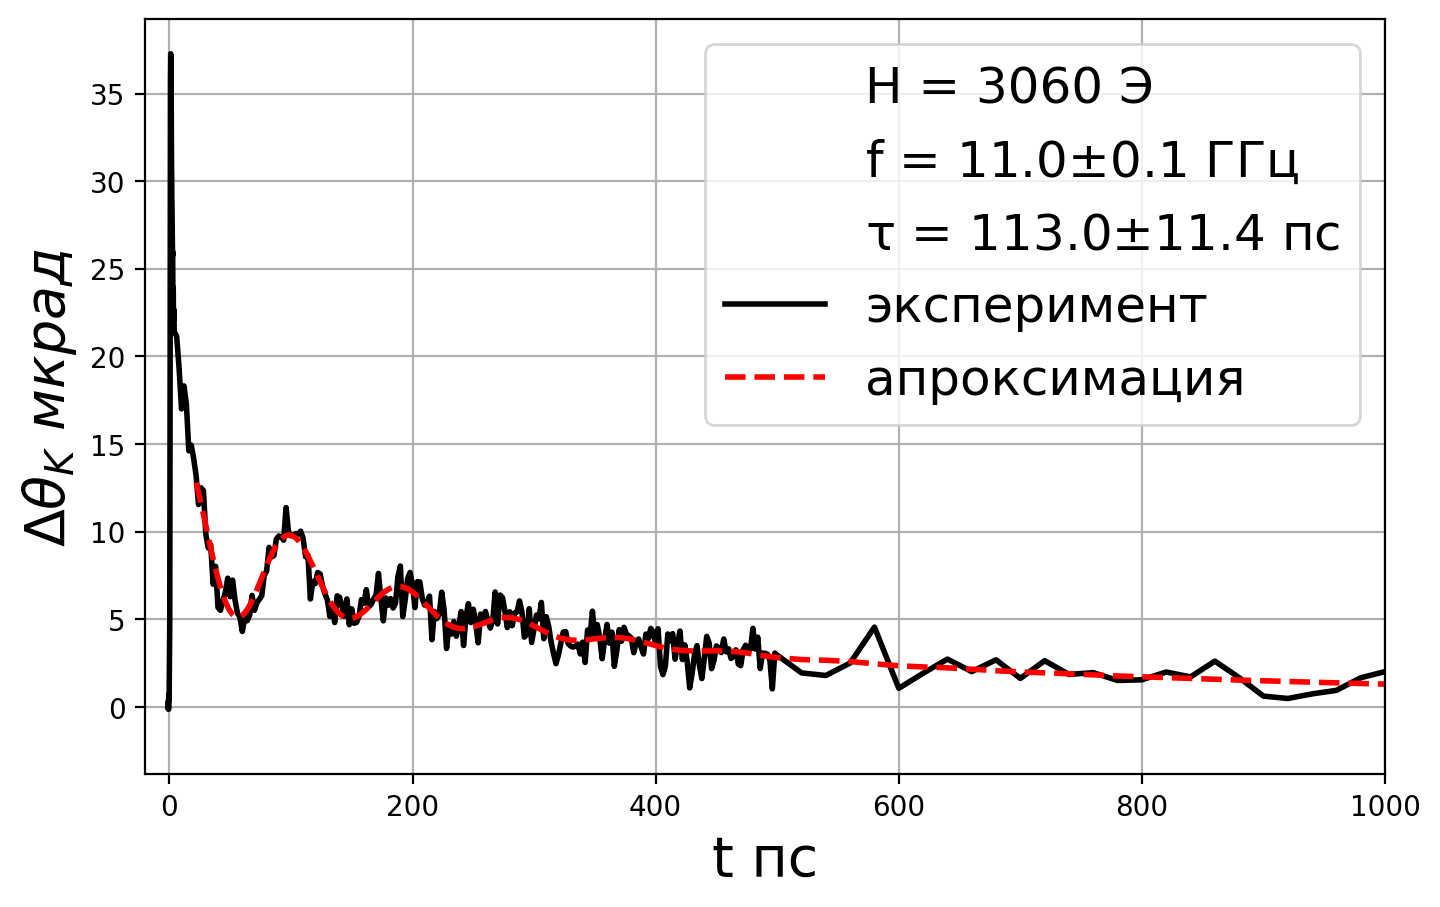

In [95]:
%matplotlib inline
from scipy.optimize import curve_fit
import matplotlib.patheffects as pe

#---------WARNING----------
print("WARNING")
M_t0 = 20e-12
print("M_t0 set to {}".format(M_t0))
print()
#---------WARNING----------

def func3(x, fi0, f, tau1, tau2, tau3, A1, A2, A3, C):
    #       1-oscillations                                      2-M relaxation              3-Ku relaxation
    return A1*np.exp(-x/tau1)*np.cos(2*np.pi*f*x + fi0) + C + A2*np.exp(-(x-M_t0)/tau2) + A3*np.exp(-(x-M_t0)/tau3)

def func2(x, fi0, f, tau1, tau2,  A1, A2, C):
    #       1-oscillations                                      2-M relaxation         
    return A1*np.exp(-x/tau1)*np.cos(2*np.pi*f*x + fi0) + C + A2*np.exp(-(x-M_t0)/tau2) 

def func1(x, fi0, f, tau1, A1, C):
    #       1-oscillations                                      2-M relaxation         
    return A1*np.exp(-x/tau1)*np.cos(2*np.pi*f*x + fi0) + C


par, pcov = curve_fit(
    func3,
    wtt[wtt>M_t0],
    wtd[wtt>M_t0],
    # 1 - oscillation, 2 - M relaxation, 3 - Ku relaxation
    #  fi0, f,   tau1,    tau2,  tau3,   A1, A2, A3, C
    p0=[0, 9e9, 25e-12, 300e-12, 60e-12, 20., -40., -200., 0.],
    maxfev=1000
)

#par, ss = curve_fit(
#    func2,
#    df.t[df.t>M_t0],
#    what_to[df.t>M_t0],
#    # 1 - oscillation, 2 - M relaxation, 3 - Ku relaxation
#    #   fi0, f,   tau1,    tau2,   A1,  A2,  C
#    p0=[0, 12e9, 100e-12, 10e-12, 50., -5., 650.],
#    maxfev=1000
#)


#par, ss = curve_fit(
#    func1,
#    df.t[df.t>M_t0],
#    what_to[df.t>M_t0],
#    # 1 - oscillation, 2 - M relaxation, 3 - Ku relaxation
#    #  fi0, f,   tau1,    tau2,  tau3,   A1, A2, A3, C
#    #p0=[0, 60e9, 25-12, M_tau, Ku_tau, 0.1., 1., 0., 400.],
#    p0=[0, 15e9, 25e-12, 1., 475.],
#    maxfev=1000,
#)

print(par)
print("f={} +- {} GHz".format(par[1]*1e-9, np.sqrt(pcov[1][1])*1e-9))
print("tau_f={} +- {} ps".format(par[2]*1e12, np.sqrt(pcov[2][2])*1e12))
print("A1={}".format(par[5]))
print("tau2={}+-{}".format(par[3]*1e12, np.sqrt(pcov[3][3])*1e12))
print("A2={}".format(par[6]))
print("tau3={}".format(par[4]*1e12))
print("A3={}".format(par[7]))
print("A2/A3={}".format(par[6]/par[7]))


plt.figure(figsize=(8, 5), dpi=200)
plt.plot([], [], ' ', label="H = {} Э".format(moke_H[ind]))
plt.plot([], [], ' ', label=r"f = {:.1f}$\pm${:.1f} ГГц".format(par[1]*1e-9, np.sqrt(pcov[1][1])*1e-9))
plt.plot([], [], ' ', label=r"τ = {:.1f}$\pm${:.1f} пс".format(par[2]*1e12, np.sqrt(pcov[2][2])*1e12))


plt.plot(wtt*1e12, wtd, 'k-', label='эксперимент', markersize=3, linewidth=2)
plt.plot(wtt[wtt>M_t0]*1e12, func3(wtt[wtt>M_t0], *par), '--', label='апроксимация', linewidth=2, color='red')
#plt.plot(df.t[df.t>M_t0]*1e12, func2(df.t[df.t>M_t0], *par), linestyle='-', linewidth=2, color='red', label='апроксимация')
#plt.plot(df.t[df.t>M_t0]1e12, func1(df.t[df.t>M_t0], *par))
plt.xlim(-20, 1000)
plt.xlabel("t пс", fontsize=20)
plt.ylabel(r"$Δθ_K\ мкрад$", fontsize=20)
plt.grid(True)
#plt.text(0,0,"H = {} кЭ".format(moke_H[ind]/1000))
#plt.title("H = {} кЭ".format(moke_H[ind]/1000))
plt.legend(fontsize=18)

<IPython.core.display.Javascript object>


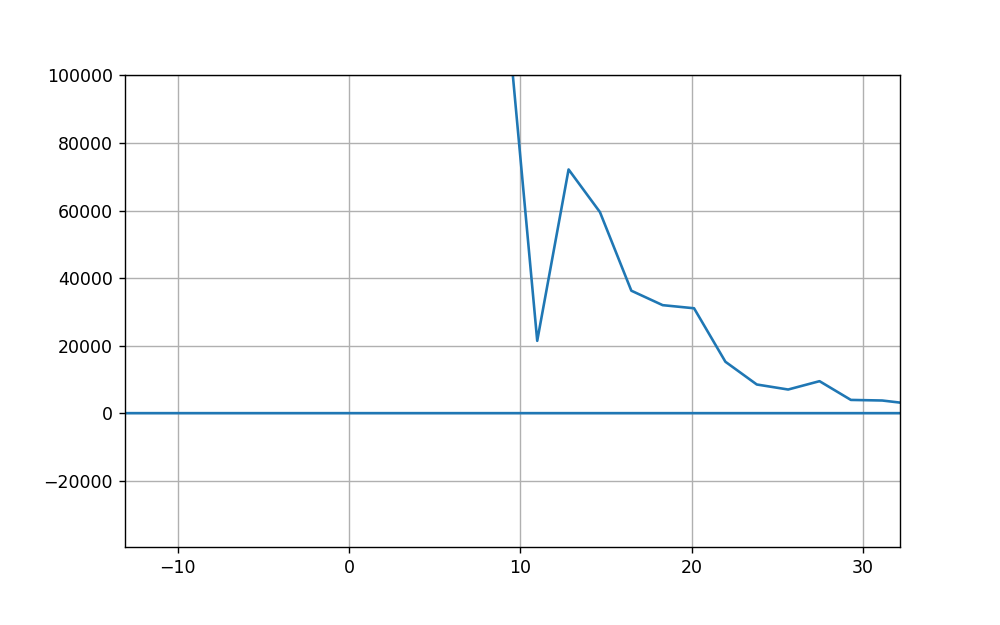

In [96]:
%matplotlib notebook
wtd = wtd[wtt<450e-12]
wtt = wtt[wtt<450e-12]

freq = np.fft.fftfreq(len(wtd), 2e-12)[1:200] * 1e-9
spectre = np.abs(np.fft.fft(wtd))[1:200]**2

plt.figure(figsize=(8, 5), dpi= 100)
plt.plot(freq, spectre)
plt.grid(True)

In [67]:
display(wtt[50])
display(wtt[51])


4e-12

6e-12